# **Text Classification of Product Descriptions Using TF-IDF and Log Loss Optimization**
The aim of this work is to perform text preprocessing and **TF-IDF analysis** on **product ID** descriptions, which are associated with a total of **16 distinct labels**. The goal is to identify the model that, using TF-IDF features, **minimizes the log loss**.

In [1]:
import csv
import numpy as np


- the text file that contains the descriptions associated with the products' ids

In [ ]:
descriptions = dict()
with open(r"/description.txt", "r") as f:
    for line in f:
        t = line.split('|=|')
        descriptions[int(t[0])] = t[1][:-1]


---

**TODO##**

- library.py with the functions : ex. `clean_text_with_lemma`

In [ ]:
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


In [ ]:

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Full NLP preprocessing function with lemmatization
def clean_text_with_lemma(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Use spaCy to tokenize and lemmatize
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if token.lemma_.lower() not in STOP_WORDS
        and not token.is_punct
        and not token.is_space
        and not token.like_num
    ]

    return ' '.join(tokens)

- Load the **preprocessed labeled train and test sets** which have been splitted with stratifying method

In [2]:
from IPython.display import display, HTML
import pandas as pd

train_df = pd.read_csv(r'/train.csv')
test_df = pd.read_csv(r'/test.csv')

- check for missing values in train and test set

In [3]:
# Find rows with missing 'description' in train_df
missing_train = train_df[train_df['text_clean'].isnull()]

# Find rows with missing 'description' in test_df
missing_test = test_df[test_df['text_clean'].isnull()]

# Print the rows with missing values
print("Rows with missing 'description' in train_df:")
print(missing_train)

print("\nRows with missing 'description' in test_df:")
print(missing_test)


Rows with missing 'description' in train_df:
       product_id text_clean  label
89285      265165        NaN      7

Rows with missing 'description' in test_df:
       product_id text_clean  label
34767      174103        NaN      5


- remove missing values

In [4]:
# Remove rows with missing 'description' in train_df
train_df = train_df.dropna(subset=['text_clean'])

# Remove rows with missing 'description' in test_df
test_df = test_df.dropna(subset=['text_clean'])

# Verify if any rows with missing values remain
print("Missing values in cleaned train_df:", train_df.isnull().sum())
print("Missing values in cleaned test_df:", test_df.isnull().sum())


Missing values in cleaned train_df: product_id    0
text_clean    0
label         0
dtype: int64
Missing values in cleaned test_df: product_id    0
text_clean    0
label         0
dtype: int64


- reset index after removing missing values

In [5]:
# Reset the index after removing rows with missing values
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Check the first few rows to confirm that the index is reset
print(train_df.head())
print(test_df.head())


   product_id                                         text_clean  label
0      114704  hornady unprimed winchester cartridge case hor...      2
1      250731  tachikara tk leopard knee pad tachikara tk leo...     11
2      152967  g asd replacement cutter aluminum amp carbon u...      2
3        4541  mtech usa mt tactical folding knife inch close...      2
4      142062  nhl pittsburgh penguins game day black pro sha...      7
   product_id                                         text_clean  label
0       56218                             katz hoodie volleyball      0
1       42346  vz grip operator ii standard size gun grip mak...      2
2      215842  tough flat leather hobble tough flat leather h...     15
3       36062  buzzrack skipper bicycle suv hatchback wheel c...      1
4      188250  cuisinart cgg allfood btu portable outdoor tab...     10


In [6]:
train_df.columns = ['product_id', 'description', 'label']
test_df.columns = ['product_id', 'description', 'label']

display(HTML(train_df.tail(5).to_html(escape=False)))

,product_id,description,label
145598,12805,mlb san francisco giants baseball pet collar reflective,7
145599,153531,daiwa ecxhfb emcast surf rod cast foot extra heavy piece pound emcast offer broad selection unique rod action cover wide variety specific fishing condition xtube blank protection prevent scratch wear rod rod holder cast rodfeet extra heavy piece pound,2
145600,137219,speedo splatter silicone cap swimmer choose speedo swim cap brand world artsy graphic print cap make soft silicone insure comfort durability day wear easy pull hair pvc free great choice recreational competitive swimmer,4
145601,111672,wingflyer z classic white,9
145602,223512,condor tactical leg holster condor tactical leg holsterquickly draw pistol intense situation leg holster condorfeature,2


In [ ]:
print(len(train_df))
print(len(test_df))

145603
36401


In [ ]:
import numpy as np
print(np.unique(train_df['label']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [ ]:
display(HTML(test_df.tail(5).to_html(escape=False)))

,product_id,description,label
36396,32546,dolfin grafika poly reversible chloroban polyester reverse solid color,4
36397,158260,new black lace embroidery uv protection sun block light weight trifold umbrella parasol manual openclose tri fold umbrellalight weigt easy carrysturdy wind resistant frameleave open dry,10
36398,270154,tnt room cabin tent xx room cabin tent sleep large door spacious window complete storage bag stake,10
36399,241734,schrade badger knife quot overall length fix blade schrade badger fix blade knive sheath suregrip handle overall length limit lifetime warranty,2
36400,227141,florida gators new era white fit hat cap nwt,7


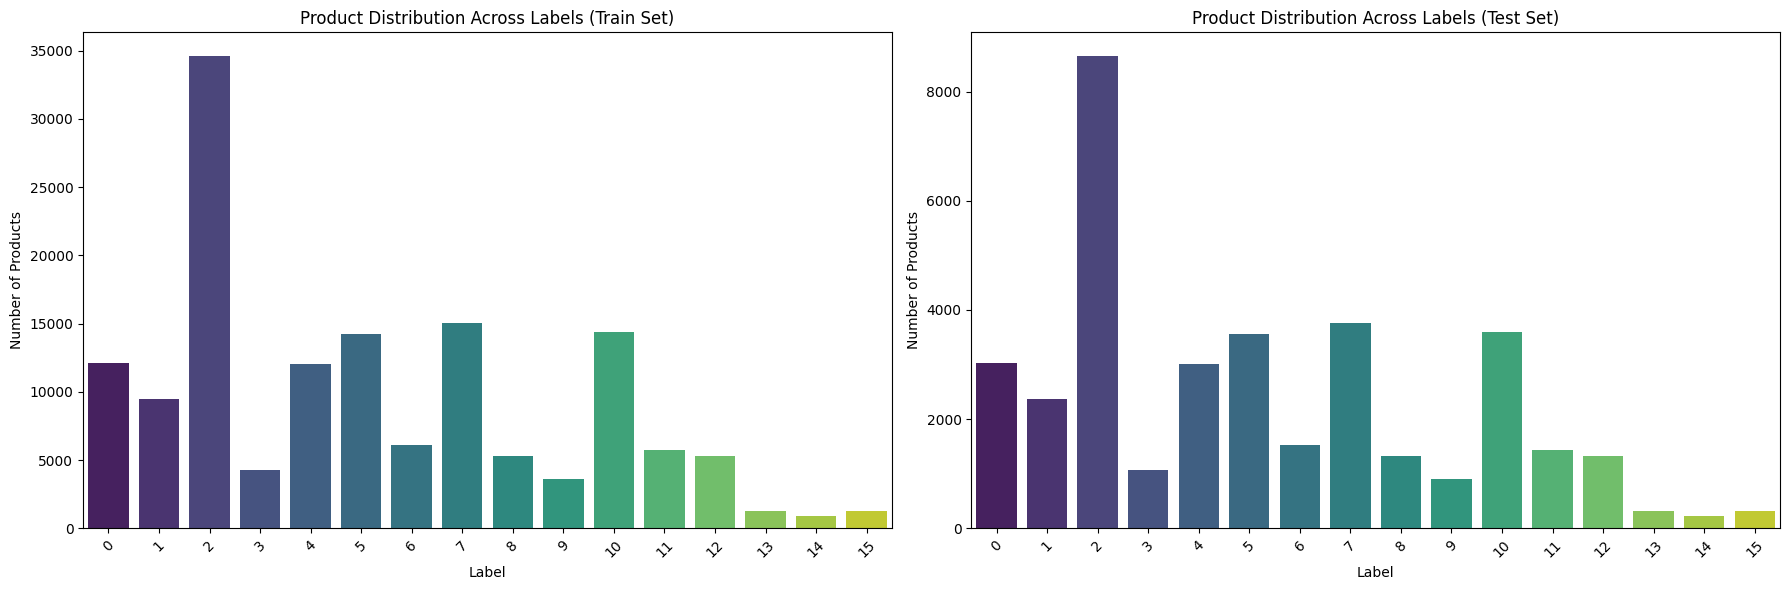

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

label_counts_train = train_df['label'].value_counts().sort_index()  # Sort by label to ensure 0, 1, 2... order
label_counts_test = test_df['label'].value_counts().sort_index()  # Sort by label to ensure 0, 1, 2... order

# Create a bar plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot for Train Set
sns.barplot(x=label_counts_train.index, y=label_counts_train.values, palette='viridis', ax=axes[0], hue=None)
axes[0].set_title('Product Distribution Across Labels (Train Set)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Products')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Test Set
sns.barplot(x=label_counts_test.index, y=label_counts_test.values, palette='viridis', ax=axes[1], hue=None)
axes[1].set_title('Product Distribution Across Labels (Test Set)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Products')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
display(HTML(train_df.tail(5).to_html(escape=False)))

,product_id,description,label
145598,12805,mlb san francisco giants baseball pet collar reflective,7
145599,153531,daiwa ecxhfb emcast surf rod cast foot extra heavy piece pound emcast offer broad selection unique rod action cover wide variety specific fishing condition xtube blank protection prevent scratch wear rod rod holder cast rodfeet extra heavy piece pound,2
145600,137219,speedo splatter silicone cap swimmer choose speedo swim cap brand world artsy graphic print cap make soft silicone insure comfort durability day wear easy pull hair pvc free great choice recreational competitive swimmer,4
145601,111672,wingflyer z classic white,9
145602,223512,condor tactical leg holster condor tactical leg holsterquickly draw pistol intense situation leg holster condorfeature,2


In [ ]:
from collections import Counter

all_words = " ".join(train_df['description'].dropna()).split()
word_freq = Counter(all_words)

# How many words occur more than 5 times?
common_words = [word for word, count in word_freq.items() if count > 5]
print(f"Words occurring more than 5 times: {len(common_words)}")


Words occurring more than 5 times: 33033


In [ ]:
token_counts = train_df['description'].dropna().apply(lambda x: len(x.split()))
avg_tokens = token_counts.mean()
print(f"Average number of tokens per description: {avg_tokens:.2f}")


Average number of tokens per description: 45.89


- load preprocess the **unlabeled test set**

In [ ]:
# Read test data
test_data = list()
with open("/test.txt", "r") as f:
    for i,line in enumerate(f):
        t = line.split(',')
        test_data.append(int(t[0]))

# Retrieve descriptions of products in the test set
test_text = list()
for i in test_data:
    test_text.append(descriptions[i])

test_text[:1]

# Apply the cleaning function to each item in the list
test_text_cleaned = [clean_text_with_lemma(text) for text in test_text]




---
- **TFIDF Analysis**

In [7]:
X_train = train_df['description']
y_train = train_df['label']

X_test = test_df['description']
y_test = test_df['label']

In [ ]:
y_train.unique()


array([ 2, 11,  7, 10,  3, 15,  6,  5,  0,  1,  4, 12,  8,  9, 14, 13])

In [14]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.95)


# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train) # labeled train set
X_tfidf_test = tfidf_vectorizer.transform(X_test) # labeled test set
#X_tfidf_test_comp =  tfidf_vectorizer.transform(test_text_cleaned) # unlabeled test set

- 145,604 descriptions.
- 261,188 unique n-grams

In [ ]:
# View the shape only
print(X_tfidf_train.shape)

# Inspect just a few rows and columns
print(X_tfidf_train[:5, :10].toarray())


(145604, 261188)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


- **log-loss** function

In [8]:
import numpy as np
from sklearn.preprocessing import label_binarize

def multiclass_log_loss(y_true, y_pred_proba, eps=1e-15):
    """
    y_true: array-like of shape (N,) - true class labels
    y_pred_proba: array-like of shape (N, C) - predicted class probabilities
    """
    # Number of samples
    N = y_true.shape[0]

    # One-hot encode the true labels (yij)
    y_true_one_hot = label_binarize(y_true, classes=np.arange(y_pred_proba.shape[1]))

    # Clip predicted probabilities to avoid log(0)
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    # Compute the log loss
    loss = -np.sum(y_true_one_hot * np.log(y_pred_proba)) / N
    return loss


---
- LogisticRegression

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(decode_error='ignore', strip_accents='unicode', min_df=5, max_df=0.95, max_features=20000)

# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train_example = tfidf.fit_transform(X_train)
X_tfidf_test_example = tfidf.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# Initialize and train the model
lr_model = LogisticRegression(solver='saga', max_iter=5000, random_state=42)
lr_model.fit(X_tfidf_train, y_train)

# Make predictions and evaluate
y_pred = lr_model.predict(X_tfidf_test)
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3033
           1       0.88      0.87      0.87      2372
           2       0.88      0.96      0.92      8652
           3       0.95      0.93      0.94      1073
           4       0.93      0.92      0.93      3016
           5       0.94      0.95      0.95      3565
           6       0.94      0.89      0.92      1519
           7       0.96      0.92      0.94      3752
           8       0.95      0.93      0.94      1316
           9       0.94      0.88      0.91       903
          10       0.87      0.85      0.86      3589
          11       0.92      0.89      0.90      1425
          12       0.91      0.75      0.82      1318
          13       0.93      0.75      0.83       323
          14       0.98      0.78      0.87       226
          15       0.96      0.83      0.89       320

    accuracy                        

In [ ]:
# Predict probabilities
y_proba = lr_model.predict_proba(X_tfidf_test)

# Compute custom log loss
custom_loss = multiclass_log_loss(y_test, y_proba)
print(f"Manual Log Loss: {custom_loss:.4f}")


Manual Log Loss: 0.3783


In [ ]:
# Predict probabilities
y_proba_train = lr_model.predict_proba(X_tfidf_train)

# Compute custom log loss
custom_loss = multiclass_log_loss(y_train, y_proba_train)
print(f"Manual Log Loss: {custom_loss:.4f}")


Manual Log Loss: 0.2942


---
- SVM

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report


In [ ]:
# Initialize the SVM model (using linear kernel for text data)
svm_model = SVC(kernel='poly', probability=True, random_state=42)

# Train the final model on the full training data
svm_model.fit(X_tfidf_train_example, y_train)

# Evaluate on the test set
y_pred_svm = svm_model.predict(X_tfidf_test_example)

print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm))


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm = LinearSVC(max_iter=1000)
svm_model = CalibratedClassifierCV(base_svm, cv=3)  # Platt scaling internally

svm_model.fit(X_tfidf_train, y_train)

y_pred_svm = svm_model.predict(X_tfidf_test)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm))


y_proba_svm = svm_model.predict_proba(X_tfidf_test)

# Compute custom log loss
custom_loss_svm = multiclass_log_loss(y_test, y_proba_svm)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm:.4f}")


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3033
           1       0.91      0.90      0.91      2372
           2       0.92      0.95      0.93      8652
           3       0.97      0.97      0.97      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3565
           6       0.95      0.93      0.94      1519
           7       0.96      0.94      0.95      3752
           8       0.96      0.96      0.96      1316
           9       0.95      0.94      0.94       903
          10       0.88      0.87      0.88      3589
          11       0.92      0.92      0.92      1425
          12       0.90      0.82      0.85      1318
          13       0.91      0.86      0.89       323
          14       0.97      0.96      0.96       226
          15       0.95      0.92      0.93       320

    accuracy                           0.93    

In [ ]:
y_proba_svm_comp = svm_model.predict_proba(X_tfidf_test_comp)

import csv
with open('/best.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_proba_svm_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

---
- SVM with the BEST results

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm2 = LinearSVC(max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm2, cv=5)  # Platt scaling internally

svm_model2.fit(X_tfidf_train, y_train)

y_pred_svm2 = svm_model2.predict(X_tfidf_test)
print("\nSVM Final Test Set Performance:")


y_proba_svm2 = svm_model2.predict_proba(X_tfidf_test)

# Compute custom log loss
custom_loss_svm2 = multiclass_log_loss(y_test, y_proba_svm2)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm2:.4f}")


SVM Final Test Set Performance:
Probabilistic Log Loss (SVM): 0.2525


In [ ]:
y_proba_svm_comp = svm_model2.predict_proba(X_tfidf_test_comp)

import csv
with open('/svm.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_proba_svm_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

(36402,)


---
- RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import cross_val_score

# 1. Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    max_depth=None         # Let the trees grow fully (adjustable)
)

# 2. Fit the model
rf_model.fit(X_tfidf_train, y_train)

# 3. Predict class probabilities for log loss
y_proba_rf = rf_model.predict_proba(X_tfidf_test)

# 4. Predict class labels for classification report
y_pred_rf = rf_model.predict(X_tfidf_test)

# 5. Evaluate
print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))

# 6. Log Loss (for competition)
custom_loss_rf = multiclass_log_loss(y_test, y_proba_rf)
print(f"Probabilistic Log Loss (SVM): {custom_loss_rf:.4f}")

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3033
           1       0.91      0.83      0.87      2372
           2       0.84      0.96      0.89      8652
           3       0.95      0.94      0.94      1073
           4       0.93      0.87      0.90      3016
           5       0.91      0.95      0.93      3565
           6       0.95      0.88      0.91      1519
           7       0.96      0.93      0.94      3752
           8       0.96      0.89      0.92      1316
           9       0.96      0.88      0.92       903
          10       0.87      0.80      0.83      3589
          11       0.91      0.86      0.88      1425
          12       0.92      0.73      0.81      1318
          13       0.94      0.65      0.77       323
          14       0.99      0.83      0.91       226
          15       0.96      0.78      0.86       320

    accuracy                           0.9

---
- xboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, log_loss

# 1. Initialize the model
xgb_model = XGBClassifier(
    objective='multi:softprob',  # Needed for multiclass probability output
    num_class=len(np.unique(y_train)),  # Set number of classes
    eval_metric='mlogloss',  # Use multiclass log loss as eval metric
    use_label_encoder=False,  # Suppress warning
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# 2. Train the model
xgb_model.fit(X_tfidf_train, y_train)

# 3. Predict probabilities and labels
y_proba_xgb = xgb_model.predict_proba(X_tfidf_test)
y_pred_xgb = xgb_model.predict(X_tfidf_test)

# 4. Evaluation
print("XGBoost - Classification Report")
print(classification_report(y_test, y_pred_xgb))

# 5. Log loss
loss_xgb = multiclass_log_loss(y_test, y_proba_xgb)
print(f"XGBoost - Multiclass Log Loss: {loss_xgb:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:04:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3033
           1       0.86      0.78      0.82      2372
           2       0.71      0.94      0.81      8652
           3       0.94      0.92      0.93      1073
           4       0.91      0.76      0.83      3016
           5       0.91      0.85      0.88      3565
           6       0.93      0.81      0.87      1519
           7       0.94      0.86      0.90      3752
           8       0.94      0.85      0.89      1316
           9       0.93      0.85      0.89       903
          10       0.85      0.69      0.76      3589
          11       0.90      0.80      0.85      1425
          12       0.91      0.72      0.80      1318
          13       0.83      0.78      0.81       323
          14       0.97      0.91      0.94       226
          15       0.96      0.77      0.85       320

    accuracy                           0.84     

---
- GridSearch svm

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Define base model
base_svm = LinearSVC(max_iter=1000)

# Wrap in CalibratedClassifierCV
calibrated_svm = CalibratedClassifierCV(estimator=base_svm, cv=3)

# Define parameter grid using 'estimator__' prefix
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__loss': ['hinge', 'squared_hinge']
}

# Use GridSearchCV
grid_search = GridSearchCV(calibrated_svm, param_grid, cv=5, scoring='neg_log_loss', n_jobs=-1)

# Fit to data
grid_search.fit(X_tfidf_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best log loss:", -grid_search.best_score_)


Best parameters: {'estimator__C': 1, 'estimator__loss': 'squared_hinge'}
Best log loss: 0.27203531784274526


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm_tune = LinearSVC(C=1, loss='squared_hinge', max_iter=1000)

svm_model_tune = CalibratedClassifierCV(base_svm_tune, cv=3)  # Platt scaling internally

svm_model_tune.fit(X_tfidf_train, y_train)

y_pred_svm_tune = svm_model_tune.predict(X_tfidf_test)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm_tune))


y_proba_svm_tune = svm_model_tune.predict_proba(X_tfidf_test)


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.91      0.90      0.91      2372
           2       0.92      0.95      0.93      8652
           3       0.96      0.96      0.96      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3565
           6       0.95      0.94      0.94      1519
           7       0.96      0.94      0.95      3752
           8       0.97      0.95      0.96      1316
           9       0.95      0.93      0.94       903
          10       0.89      0.88      0.88      3589
          11       0.92      0.92      0.92      1425
          12       0.89      0.81      0.85      1318
          13       0.91      0.86      0.89       323
          14       0.97      0.95      0.96       226
          15       0.96      0.93      0.94       320

    accuracy                           0.93    

In [ ]:
# Compute custom log loss
custom_loss_svm_tune = multiclass_log_loss(y_test, y_proba_svm_tune)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm_tune:.4f}")

Probabilistic Log Loss (SVM): 0.2551


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import train_test_split

# Split the dataset
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_tfidf_train, y_train, test_size=0.2, random_state=42
)

# Fixed value of C
FIXED_C = 1.0

# Optuna objective function
def objective(trial):
    max_iter = trial.suggest_int('max_iter', 500, 5000)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    base_svm = LinearSVC(
        C=FIXED_C,
        max_iter=max_iter,
        tol=tol,
        penalty='l2',
        loss='squared_hinge',
        class_weight=class_weight,
        dual=False
    )

    clf = CalibratedClassifierCV(base_svm, cv=3)

    try:
        clf.fit(X_train_split, y_train_split)
        y_proba = clf.predict_proba(X_val_split)
        return log_loss(y_val_split, y_proba)
    except Exception as e:
        trial.set_user_attr("fail_reason", str(e))
        return float('inf')

# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Best parameters
best_params = study.best_params
print("Best params (with fixed C=1.0):", best_params)

# Final model with best hyperparameters and fixed C
final_svm = LinearSVC(
    C=FIXED_C,
    max_iter=best_params['max_iter'],
    tol=best_params['tol'],
    penalty='l2',
    loss='squared_hinge',
    class_weight=best_params['class_weight'],
    dual=False
)
svm_model = CalibratedClassifierCV(final_svm, cv=3)
svm_model.fit(X_tfidf_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_tfidf_test)
y_proba_svm = svm_model.predict_proba(X_tfidf_test)

print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm))
final_log_loss = log_loss(y_test, y_proba_svm)
print("Final Log Loss on Test Set:", final_log_loss)


[I 2025-05-05 16:48:08,818] A new study created in memory with name: no-name-1676717d-0893-4e92-9cf5-b8d741aa636f
[I 2025-05-05 16:50:01,955] Trial 0 finished with value: 0.27255805068390176 and parameters: {'max_iter': 2876, 'tol': 6.541642714489717e-05, 'class_weight': None}. Best is trial 0 with value: 0.27255805068390176.
[I 2025-05-05 16:52:05,995] Trial 1 finished with value: 0.27255422222374526 and parameters: {'max_iter': 4535, 'tol': 4.016000894916592e-06, 'class_weight': None}. Best is trial 1 with value: 0.27255422222374526.


---
- voting

- DONT use svc, random forest, logistic, nb together doesnt work!

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Base models
svc = LinearSVC(max_iter=3000)
calibrated_svc = CalibratedClassifierCV(svc, cv=5)  # Needed for predict_proba

nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=3000)

# Create a soft voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('svc', calibrated_svc),
        ('nb', nb),
        ('lr', lr)
    ],
    voting='soft'  # Use probabilities for voting
)

# Fit ensemble on training data
voting_clf.fit(X_tfidf_train, y_train)

# Predictions
y_pred = voting_clf.predict(X_tfidf_test)
print("\nVoting Classifier Final Test Set Performance:")
print(classification_report(y_test, y_pred))

# Probability predictions
y_proba_voting = voting_clf.predict_proba(X_tfidf_test)


# Compute custom log loss
custom_loss_voting = multiclass_log_loss(y_test, y_proba_voting)
print(f"Probabilistic Log Loss (voting): {custom_loss_voting:.4f}")


Voting Classifier Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3033
           1       0.92      0.87      0.89      2372
           2       0.87      0.97      0.92      8652
           3       0.97      0.94      0.95      1073
           4       0.95      0.92      0.93      3016
           5       0.95      0.96      0.95      3565
           6       0.96      0.92      0.94      1519
           7       0.96      0.93      0.95      3752
           8       0.97      0.94      0.95      1316
           9       0.96      0.91      0.94       903
          10       0.89      0.85      0.87      3589
          11       0.93      0.89      0.91      1425
          12       0.94      0.73      0.82      1318
          13       0.94      0.79      0.86       323
          14       0.99      0.90      0.94       226
          15       0.99      0.85      0.91       320

    accuracy                     

In [ ]:
y_proba_voting_train = voting_clf.predict_proba(X_tfidf_train)


# Compute custom log loss
custom_loss_voting_train = multiclass_log_loss(y_train, y_proba_voting_train)
print(f"Probabilistic Log Loss (voting): {custom_loss_voting_train:.4f}")

Probabilistic Log Loss (voting): 0.1841


---

- different tfidf analysis with Selecting the k best features

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, log_loss

# ======== TF-IDF Transformation ========
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),         # include unigrams + bigrams
    min_df=5,                   # remove rare terms
    max_df=0.85,                # remove overly common terms
    sublinear_tf=True,          # log-scale term frequencies
    stop_words='english',      # remove stopwords
    max_features=20000          # limit dimensionality
)

X_tfidf_train = tfidf.fit_transform(X_train)
X_tfidf_test = tfidf.transform(X_test)
#X_tfidf_test_comp = tfidf.transform(test_text_cleaned)

# ======== Feature Selection ========
selector = SelectKBest(score_func=chi2, k=10000)
X_sel_train = selector.fit_transform(X_tfidf_train, y_train)
X_sel_test = selector.transform(X_tfidf_test)
#X_sel_test_comp = selector.transform(X_tfidf_test_comp)

In [ ]:


# ======== SVM + Isotonic Calibration ========
base_svm = LinearSVC( max_iter=15000)
cv = StratifiedKFold(n_splits=5)
svm_model = CalibratedClassifierCV(estimator=base_svm, method='isotonic', cv=cv)

# ======== Train Model ========
svm_model.fit(X_sel_train, y_train)

# ======== Predict and Evaluate ========
y_pred = svm_model.predict(X_sel_test)
y_proba = svm_model.predict_proba(X_sel_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss = log_loss(y_test, y_proba)
print(f"\n✅ Final Log Loss (Multiclass): {logloss:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3033
           1       0.88      0.87      0.87      2372
           2       0.89      0.94      0.92      8652
           3       0.95      0.95      0.95      1073
           4       0.93      0.92      0.93      3016
           5       0.95      0.95      0.95      3565
           6       0.93      0.92      0.93      1519
           7       0.95      0.92      0.94      3752
           8       0.96      0.94      0.95      1316
           9       0.94      0.91      0.93       903
          10       0.86      0.83      0.85      3589
          11       0.91      0.90      0.90      1425
          12       0.87      0.78      0.82      1318
          13       0.91      0.83      0.87       323
          14       0.96      0.95      0.95       226
          15       0.95      0.92      0.93       320

    accuracy                           0.92     36402
  

In [ ]:
logloss = multiclass_log_loss(y_test, y_proba)
print(f"\n✅ Final Log Loss (Multiclass): {logloss:.4f}")


✅ Final Log Loss (Multiclass): 0.3085


---
- stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

stack_model = StackingClassifier(
    estimators=[
        ('svm', CalibratedClassifierCV(LinearSVC(max_iter=5000), cv=3)),
        ('nb', MultinomialNB())
        # ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)


# ======== Train Model ========
stack_model.fit(X_sel_train, y_train)

# ======== Predict and Evaluate ========
y_pred_stack = stack_model.predict(X_sel_test)
y_proba_stack = stack_model.predict_proba(X_sel_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))

logloss_stack = log_loss(y_test, y_proba_stack)
print(f"\n✅ Final Log Loss (Stacking): {logloss_stack:.4f}")

---
- SVM BEST parameters BUT WITH THE TFIDF WITH THE FEATURE SELECTION
- DIDNT WORK!

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm2 = LinearSVC(max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm2, cv=5)  # Platt scaling internally

svm_model2.fit(X_sel_train, y_train)

y_pred_svm_sel = svm_model2.predict(X_sel_test)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm_sel))


y_proba_svm_sel = svm_model2.predict_proba(X_sel_test)

# Compute custom log loss
custom_loss_svm_sel = multiclass_log_loss(y_test, y_proba_svm_sel)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm_sel:.4f}")


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3033
           1       0.88      0.86      0.87      2372
           2       0.89      0.95      0.92      8652
           3       0.96      0.94      0.95      1073
           4       0.93      0.92      0.92      3016
           5       0.95      0.94      0.95      3565
           6       0.94      0.92      0.93      1519
           7       0.95      0.92      0.94      3752
           8       0.96      0.94      0.95      1316
           9       0.94      0.91      0.92       903
          10       0.86      0.84      0.85      3589
          11       0.91      0.89      0.90      1425
          12       0.88      0.78      0.83      1318
          13       0.91      0.82      0.86       323
          14       0.98      0.94      0.96       226
          15       0.95      0.92      0.94       320

    accuracy                           0.92    

---
- mlp

In [ ]:
import os
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.cm as cm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import auc, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_tfidf_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensures class distribution is preserved
)

y_train_split = y_train_split.reset_index(drop=True)
y_val_split = y_val_split.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold

class SparseDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        if isinstance(y, pd.Series):
            self.y = y.reset_index(drop=True)
        else:
            self.y = y  # Assume already tensor or compatible

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx].toarray(), dtype=torch.float32).squeeze(0)
        y = self.y[idx] if isinstance(self.y, torch.Tensor) else torch.tensor(self.y[idx], dtype=torch.long)
        return x, y


In [ ]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_layers=None,
                 dropout=0.0, batch_norm=False, layer_norm=False,
                 classes_number=20, device=None):

        super(CustomModel, self).__init__()
        layers = []
        prev_dim = input_dim

        if hidden_layers:
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                if batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                if layer_norm:
                    layers.append(nn.LayerNorm(hidden_dim))
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, classes_number))
        self.net = nn.Sequential(*layers)

        # Ensure the model is on the correct device
        if device:
            self.to(device)

    def forward(self, x):
        return self.net(x)

def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=20, patience=5):
    train_losses, val_losses = [], []
    train_log_losses, val_log_losses = [], []
    best_val_loss = float('inf')
    best_model_path = None
    no_improvement_epochs = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_train_true, y_train_prob = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            probs = torch.softmax(y_pred, dim=1)
            y_train_true.extend(y_batch.cpu().tolist())
            y_train_prob.extend(probs.detach().cpu().tolist())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Log loss on training set
        y_train_true = np.array(y_train_true)
        y_train_prob = np.array(y_train_prob)
        train_log_loss = multiclass_log_loss(y_train_true, y_train_prob)
        train_log_losses.append(train_log_loss)

        # Validation
        model.eval()
        val_loss = 0
        y_val_true, y_val_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

                probs = torch.softmax(y_pred, dim=1)
                y_val_true.extend(y_batch.cpu().tolist())
                y_val_prob.extend(probs.cpu().tolist())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        y_val_true = np.array(y_val_true)
        y_val_prob = np.array(y_val_prob)
        val_log_loss = multiclass_log_loss(y_val_true, y_val_prob)
        val_log_losses.append(val_log_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train LogLoss: {train_log_loss:.4f} | Val LogLoss: {val_log_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_log_losses, val_log_losses


def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []  # y_prob will store probabilities for ROC curve
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class (for metrics)

            y_true.extend(y_batch.tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())  # Store probabilities for ROC curve

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    return y_true, y_pred, y_prob

# Create datasets for train, validation, and test
train_dataset = SparseDataset(X_train_split, y_train_split)
val_dataset = SparseDataset(X_val_split, y_val_split)
test_dataset = SparseDataset(X_tfidf_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

test_dataset_unlabeled = SparseDataset(X_tfidf_test_comp, torch.zeros(X_tfidf_test_comp.shape[0]))  # Dummy labels
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=64, shuffle=False)



# Re-initialize model per fold
model = CustomModel(
        input_dim=X_tfidf_train.shape[1],
        hidden_layers=[256, 128, 64],
        dropout=0.4,
        batch_norm=True,
        layer_norm=True,
        classes_number=len(np.unique(y_train_split)),
        device=device
    )


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss and optimizer (use class weights!)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

# Train the model for this fold
train_losses, val_losses, train_log_losses, val_log_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5
    )

Epoch 1/20 | Train Loss: 2.5783 | Val Loss: 1.6944 | Train LogLoss: 2.5915 | Val LogLoss: 1.7860
Epoch 2/20 | Train Loss: 1.9068 | Val Loss: 1.1423 | Train LogLoss: 1.9850 | Val LogLoss: 1.2722
Epoch 3/20 | Train Loss: 1.4346 | Val Loss: 0.7986 | Train LogLoss: 1.5479 | Val LogLoss: 0.8957
Epoch 4/20 | Train Loss: 1.1052 | Val Loss: 0.6126 | Train LogLoss: 1.2172 | Val LogLoss: 0.7147
Epoch 5/20 | Train Loss: 0.8605 | Val Loss: 0.5007 | Train LogLoss: 0.9691 | Val LogLoss: 0.5755
Epoch 6/20 | Train Loss: 0.6958 | Val Loss: 0.4319 | Train LogLoss: 0.7942 | Val LogLoss: 0.4893
Epoch 7/20 | Train Loss: 0.5751 | Val Loss: 0.3864 | Train LogLoss: 0.6617 | Val LogLoss: 0.4311
Epoch 8/20 | Train Loss: 0.4868 | Val Loss: 0.3571 | Train LogLoss: 0.5653 | Val LogLoss: 0.3979
Epoch 9/20 | Train Loss: 0.4139 | Val Loss: 0.3498 | Train LogLoss: 0.4924 | Val LogLoss: 0.4085
Epoch 10/20 | Train Loss: 0.3638 | Val Loss: 0.3337 | Train LogLoss: 0.4381 | Val LogLoss: 0.3651
Epoch 11/20 | Train Loss: 0.3

In [ ]:
y_true, y_pred, y_prob = evaluate_model(model, test_loader)
y_true_comp, y_pred_comp, y_prob_comp = evaluate_model(model, test_loader_unlabeled)

In [ ]:
test_mlp_logloss = multiclass_log_loss(y_test, y_prob)
print(test_mlp_logloss)

0.3663376645453203


In [ ]:
import csv
with open('/mlp1.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_prob_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_sel_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensures class distribution is preserved
)

# Create datasets for train, validation, and test
train_dataset = SparseDataset(X_train_split, y_train_split)
val_dataset = SparseDataset(X_val_split, y_val_split)
test_dataset = SparseDataset(X_sel_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

test_dataset_unlabeled = SparseDataset(X_sel_test_comp, torch.zeros(X_tfidf_test_comp.shape[0]))  # Dummy labels
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=64, shuffle=False)



# Re-initialize model per fold
model = CustomModel(
        input_dim=X_sel_train.shape[1],
        hidden_layers=[128, 64],
        dropout=0.4,
        batch_norm=False,
        layer_norm=True,
        classes_number=len(np.unique(y_train_split)),
        device=device
    )


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss and optimizer (use class weights!)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-2)

# Train the model for this fold
train_losses, val_losses, train_log_losses, val_log_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5
    )

Epoch 1/20 | Train Loss: 2.0217 | Val Loss: 1.1161 | Train LogLoss: 2.0217 | Val LogLoss: 1.1164
Epoch 2/20 | Train Loss: 1.1456 | Val Loss: 0.6833 | Train LogLoss: 1.1458 | Val LogLoss: 0.6840
Epoch 3/20 | Train Loss: 0.8053 | Val Loss: 0.5131 | Train LogLoss: 0.8049 | Val LogLoss: 0.5138


In [ ]:
y_true, y_pred, y_prob = evaluate_model(model, test_loader)
y_true_comp, y_pred_comp, y_prob_comp = evaluate_model(model, test_loader_unlabeled)

test_mlp_logloss = multiclass_log_loss(y_test, y_prob)
print(test_mlp_logloss)

In [ ]:
import csv
with open('/mlp2.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_prob_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

- dr=0.5, hidden=128, layernorm, lr=0.0001, wd=10-3

HERE!!!!

---
-Sematic Feature

In [15]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.95)


# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train) # labeled train set
X_tfidf_test = tfidf_vectorizer.transform(X_test) # labeled test set
#X_tfidf_test_comp =  tfidf_vectorizer.transform(test_text_cleaned) # unlabeled test set

from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-MiniLM-L6-v2')

model = SentenceTransformer('all-mpnet-base-v2')

X_embed_train = model.encode(X_train, convert_to_tensor=False)
X_embed_test = model.encode(X_test, convert_to_tensor=False)

# Concatenate TF-IDF with semantic embeddings
from scipy.sparse import hstack
X_comb_train = hstack([X_tfidf_train, X_embed_train])
X_comb_test = hstack([X_tfidf_test, X_embed_test])


#---------TRAIN BEST SVC-------------------------------------

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm2 = LinearSVC(max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm2, cv=5)  # Platt scaling internally

svm_model2.fit(X_comb_train, y_train)

y_pred_svm2 = svm_model2.predict(X_comb_test)
print("\nSVM Final Test Set Performance:")


y_proba_svm2 = svm_model2.predict_proba(X_comb_test)

# Compute custom log loss
custom_loss_svm2 = multiclass_log_loss(y_test, y_proba_svm2)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm2:.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


SVM Final Test Set Performance:
Probabilistic Log Loss (SVM): 0.2434
